## Imports

In [345]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from dataprep.eda import create_report
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from mpl_toolkits.mplot3d import Axes3D

warnings.filterwarnings('ignore')

In [346]:
# Choosen colors in most of all graphs
palette = ["#D92B6B", "#5A0B8C", "#FF5722", "#2E4DD8"]

In [347]:
df = pd.read_csv('marketing_campaign.csv', sep='\t')
df.head()

ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0  

[5 rows x 29 columns]

## EDA

In this part I used *dataprep.eda* to look into date, check it and make some decisions in feature engineering.

DataPrep Report
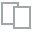
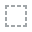
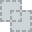
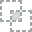
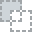
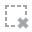
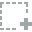
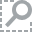
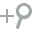
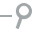
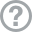
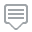
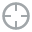
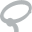
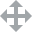
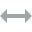
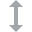
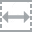
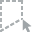
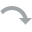
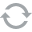
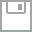
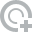
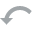
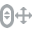
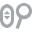
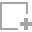
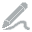
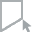
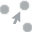
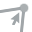
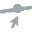

In [348]:
create_report(df)

## Feature Engineering

### This part about Feature Enineering
******
Shortly about content:
* First we need to drop ID
* Next I want to switch date of birth to years 
* Remove income outliers
* Join marital into 2 status (1-in cople, 0-not in)
* Summarize kids for each client
* Made new feature, called Buying list (sum of all categories)
* Also I did to renaming product list and AcceptedCmp(n) to Cmp(n)
* Changed category education to Hight level and medium level
* Made new feature, called Promo (sum of Cmp)
* Changing Dt_Customer to mounth
* Droped useless columns

In [349]:
#1
df = df.drop('ID', axis=1)

#2
def fixed_years(arg):
    return 2023 - arg

df['Year_Birth'] = df['Year_Birth'].apply(fixed_years)

#3
df = df[df['Income']<= 150000]

#4
def fixed_marital(arg):
    if arg in ('Married', 'Togather'):
        return 1
    else:
        return 0
    
df['Marital_Status'] = df['Marital_Status'].apply(fixed_marital)

#5
df['Kids'] = df['Kidhome'] + df['Teenhome']
df.drop(['Kidhome', 'Teenhome'], axis=1)

#6
df['Buying list'] = df['MntFishProducts'] + df['MntFruits'] + df['MntGoldProds'] + df['MntMeatProducts'] + df['MntSweetProducts'] + df['MntWines']

#7
r = []
for i in df.columns:
    i = i.replace('Mnt', '')
    i = i.replace('Products', '')
    i = i.replace('Accepted', '')
    i = i.replace('_Customer', '')
    r.append(i)

df.columns = r


#8
def fixed_education(arg):
    if arg in ('Graduation', 'PhD', 'Master'):
        return 'Hight level'
    return 'Medium level'

df['Education'] = df['Education'].apply(fixed_education)

#9
df['Promo'] = df['Cmp1'] + df['Cmp2'] + df['Cmp3'] + df['Cmp4'] + df['Cmp5']

#10
def fixed_df(arg):
    d = {1: 'Yan', 2: 'Feb', 3: 'March', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 
         'July', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'November', 12: 'December'}

    arg = int(arg.split('-')[1])
    return d[arg]

df['Dt'] = df['Dt'].apply(fixed_df)

#11
df = df.drop(['Kidhome', 'Teenhome', 'Z_CostContact', 'Z_Revenue', 'Complain'], axis=1)

## Another Research

After feature engineering I have a little bit new data, which I anylised

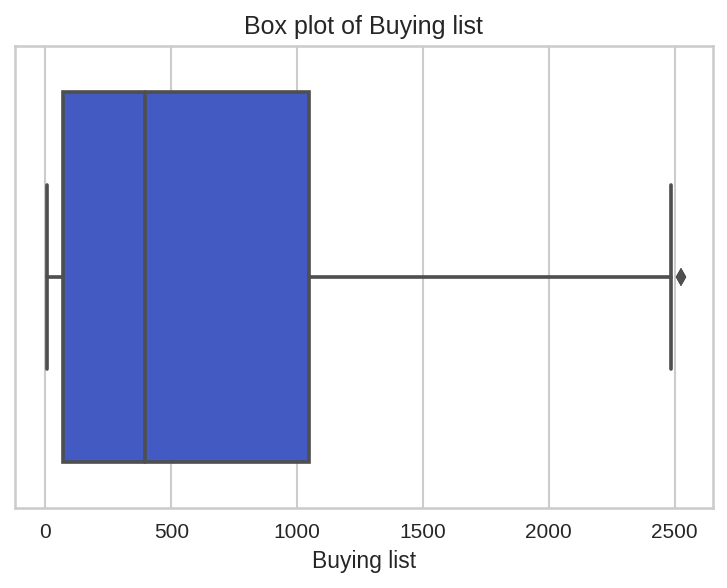

In [350]:
# Box plot of Buying list
plt.figure(dpi=150 , figsize=(6, 4))
plt.title('Box plot of Buying list')
sns.boxplot(data=df, x='Buying list', palette=palette[3:4])
plt.show()

In [351]:
# Mounth of customer's enrollment with the company with Buying list
data = df.groupby('Dt')['Buying list'].mean().sort_values()
data

Dt
Jun         504.375000
July        509.390000
March       542.413462
December    553.354286
Apr         561.255556
May         595.380282
Oct         614.328571
Yan         616.092308
Feb         631.852273
Aug         655.566820
Sep         695.130890
November    740.224044
Name: Buying list, dtype: float64

In [352]:
# Customer's marital status with Buying list
data = df.groupby('Marital_Status')['Buying list'].mean().sort_values()#bad data
data

Marital_Status
1    589.639344
0    617.747415
Name: Buying list, dtype: float64

In [353]:
# Number of children in customer's household with Buying list
data = df.groupby('Kids')['Buying list'].mean().sort_values()
data

Kids
2     247.072289
3     255.500000
1     474.426391
0    1106.774245
Name: Buying list, dtype: float64

In [354]:
# Customer's education level with Buying list
data = df.groupby('Education')['Buying list'].mean().sort_values()
data

Education
Medium level    407.098425
Hight level     632.844933
Name: Buying list, dtype: float64

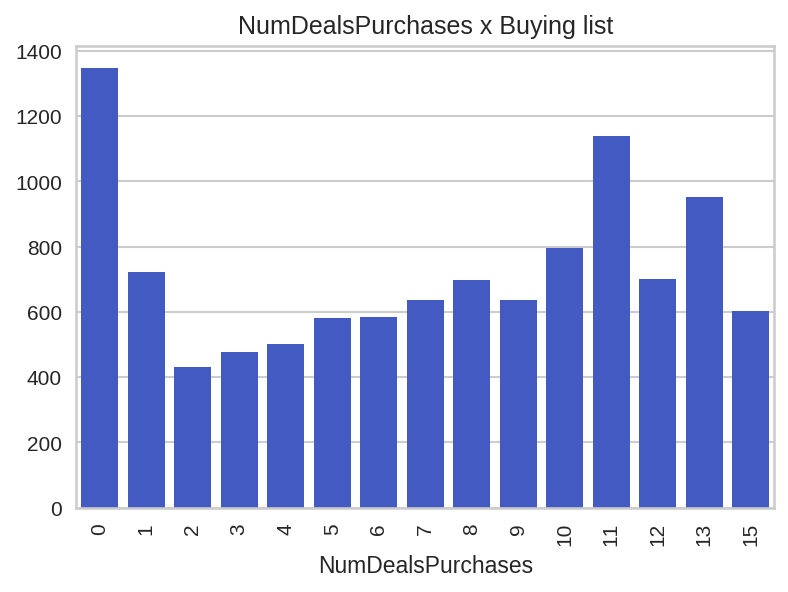

NumDealsPurchases
2      431.949290
3      477.129693
4      502.989305
5      581.840426
6      584.983333
15     601.400000
9      635.125000
7      636.179487
8      698.071429
12     700.333333
1      722.405208
10     795.400000
13     952.000000
11    1138.600000
0     1348.025641
Name: Buying list, dtype: float64



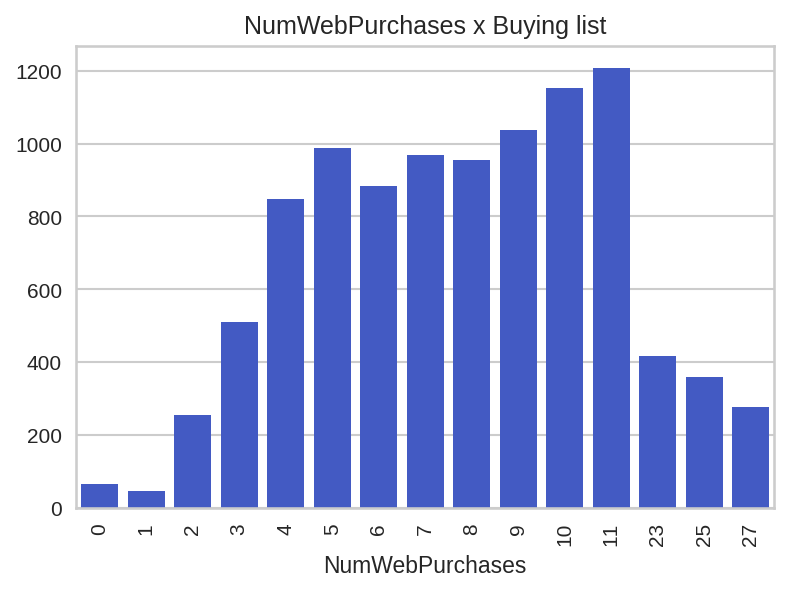

NumWebPurchases
1       47.112392
0       66.095238
2      254.307065
27     277.000000
25     359.000000
23     416.000000
3      510.516517
4      848.252708
6      884.169154
8      954.245098
7      967.922078
5      988.762557
9     1038.453333
10    1151.976744
11    1208.727273
Name: Buying list, dtype: float64



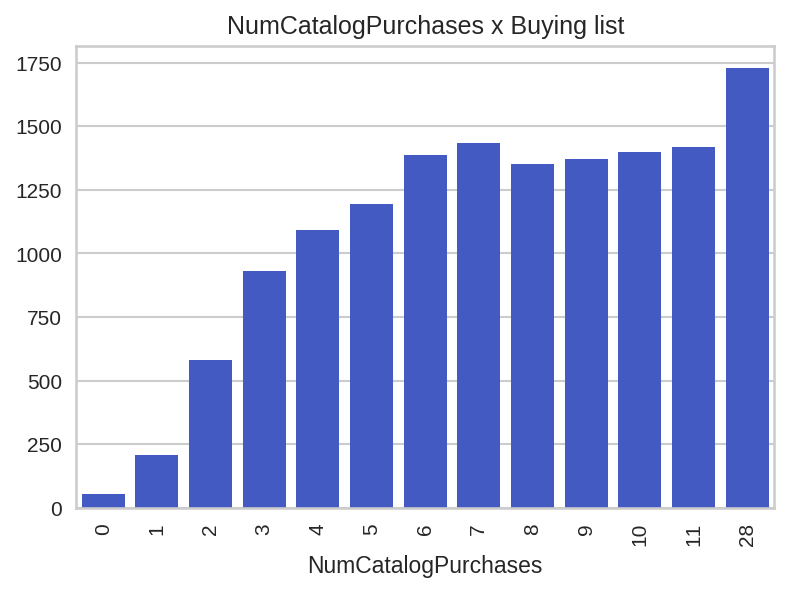

NumCatalogPurchases
0       53.312937
1      208.466395
2      579.799270
3      932.258242
4     1092.055249
5     1194.934307
8     1351.145455
9     1370.500000
6     1388.554688
10    1397.638298
11    1418.789474
7     1433.430380
28    1730.000000
Name: Buying list, dtype: float64



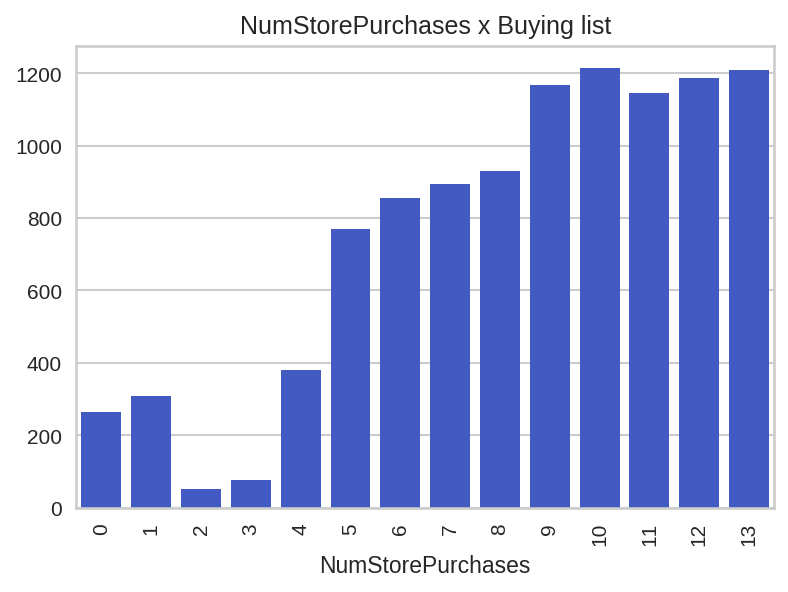

NumStorePurchases
2       50.604545
3       76.741201
0      265.300000
1      308.666667
4      381.705329
5      768.957346
6      855.920904
7      893.312057
8      930.897959
11    1146.287500
9     1166.971698
12    1187.432692
13    1208.542169
10    1215.233871
Name: Buying list, dtype: float64



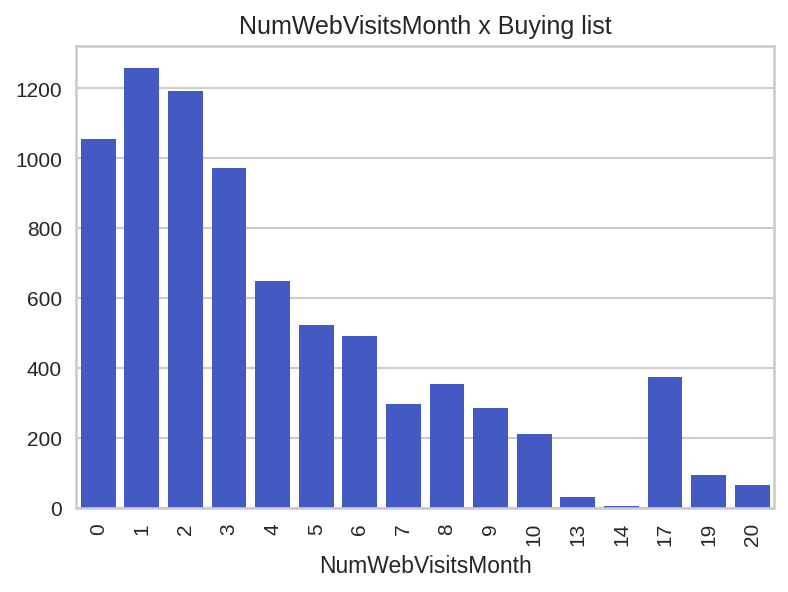

NumWebVisitsMonth
14       5.500000
13      32.000000
20      64.666667
19      93.500000
10     211.666667
9      284.280488
7      297.635659
8      354.594118
17     373.000000
6      491.523952
5      523.501792
4      650.115207
3      972.054187
0     1053.833333
2     1191.323383
1     1259.081633
Name: Buying list, dtype: float64



In [355]:
# Number of purchases if categories with Buying list
l = ['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']
for i in l:
    data = df.groupby(i)['Buying list'].mean().sort_values()
    plt.figure(dpi=150 , figsize=(6, 4))
    plt.title(f'{i} x Buying list')
    sns.barplot(x=data.index, y=data.values, palette=palette[3:4])
    plt.xticks(rotation=90)
    plt.show()
    print(data)
    print('')


In [356]:
# Marketing comapny
l = ['Cmp1', 'Cmp2', 'Cmp3', 'Cmp4', 'Cmp5']
for i in l:
    temp = df[i].sum()
    print(f'{i} - {temp} - persentage involved {round(temp*100/len(df), 3)}%')

Cmp1 - 142 - persentage involved 6.431%
Cmp2 - 30 - persentage involved 1.359%
Cmp3 - 163 - persentage involved 7.382%
Cmp4 - 164 - persentage involved 7.428%
Cmp5 - 162 - persentage involved 7.337%


In [357]:
# All promotion x Buying list
data = df.groupby('Promo')['Buying list'].mean().sort_values()
data

Promo
0     479.108062
1     917.185759
2    1409.938272
4    1501.636364
3    1705.636364
Name: Buying list, dtype: float64

### Conclusion
****
1. Clients who enrolled with the company:
Aug, Sep, November brought in the most income AVG(655.566820, 695.130890, 740.224044), Jun, July, March have worst results, maybe should make a discount in this period.
2. People who are single pending more than couple.
3. People whituot kids of have 1 kids spend a lot. 
4. People with higth level of education spend bit more.
5. Store purchases and Web views have results better than other but web have low purchases, Catalog have worst statistic but it's catalog, maybe in company this results are normal.
6. Second marketing campaign failed. Average persent of involiving 5.94%, best marketing was at 4 Cmp.

## Modeling

In this section fisrts I reduce dimension using PCA and next created model and take best for me count of clusters.

We dont use scaler because result will be bad, I tried it and as for me without scaler results are better. 

In [358]:
# We need to get dummies
df = pd.get_dummies(df)

In [359]:
# Principal component analysis
pca = PCA(n_components=3)
X_pca = pca.fit_transform(df)

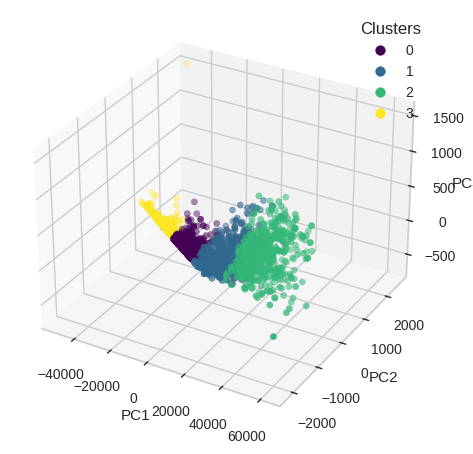

In [360]:
# Clusterisation of data
kmeans = KMeans(n_clusters=4)
clusters = kmeans.fit_predict(X_pca)

# 3D Graph
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# PCA results in graph
scatter = ax.scatter3D(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=clusters, cmap='viridis')

# Set legend
legend = ax.legend(*scatter.legend_elements(), title='Clusters')

# Labels
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.show()

We see that clusterization performed well

In [361]:
#That's cool that we reduced dimension and saved 99% information
sum(pca.explained_variance_ratio_)

0.9999788554169342

Elbow Method to determine the number of clusters to be formed:


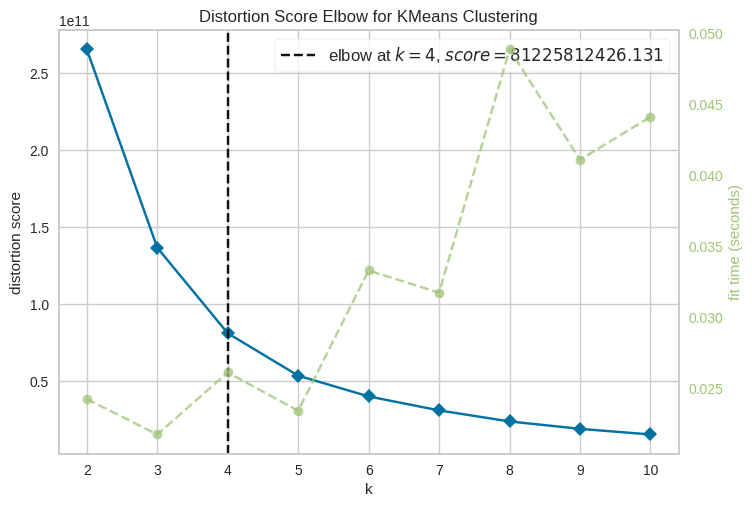

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [362]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(X_pca)
Elbow_M.show()

In [363]:
# Model fitting
model = KMeans(n_clusters=4)
model.fit(X_pca)

KMeans(n_clusters=4)

In [364]:
# Cluster labels 
cluster_labels = model.labels_

In [365]:
# Created new feature Cluster
df['Cluster'] = cluster_labels

### Conclusion of modeling
****
I used elbow method and decided to take 4 clusters. Also using PCA saved 99% information, it seems good.

## Evaluation model


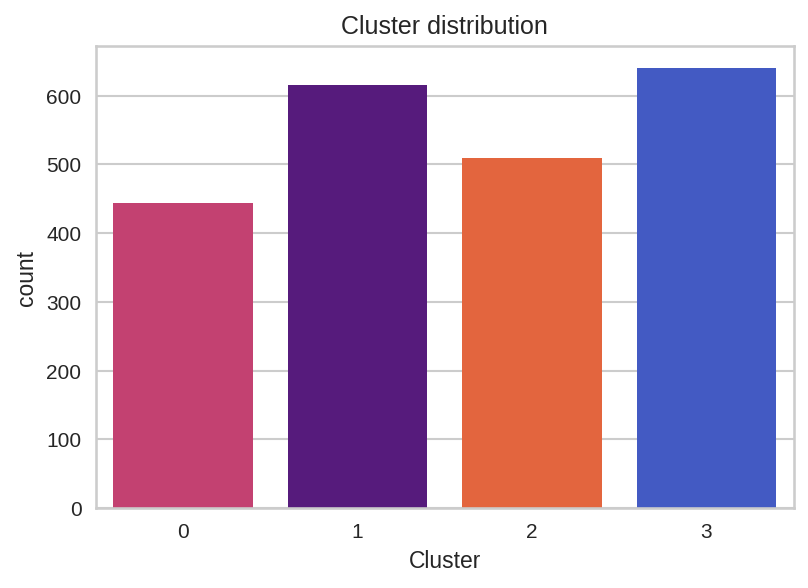

In [366]:
plt.figure(dpi=150 , figsize=(6, 4))
plt.title('Cluster distribution')
sns.countplot(data=df, x='Cluster', palette=palette)
plt.show()

We see that is's normal distribution in clusters.

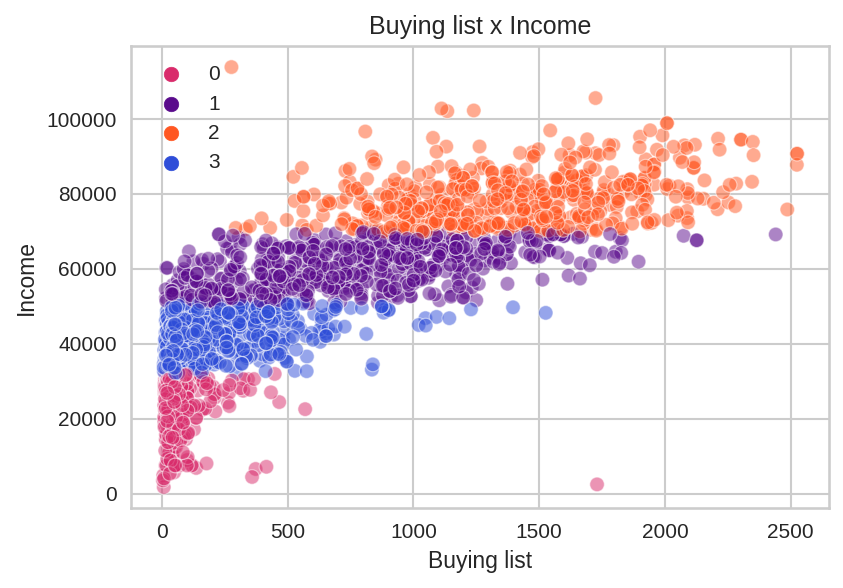

In [393]:
plt.figure(dpi=150 , figsize=(6, 4))
plt.title('Buying list x Income')
sns.scatterplot(data=df, x="Buying list", y="Income", hue="Cluster", palette=palette, alpha=0.5)
plt.legend()
plt.show()

**We have 4 clusters**

In this graph we exactly see well detachable clusters

* 0 - higth income, hight buying  

* 1 - medium income, low Buying

* 2 - low Income, low Buying 

* 3 - hight income, medium buying




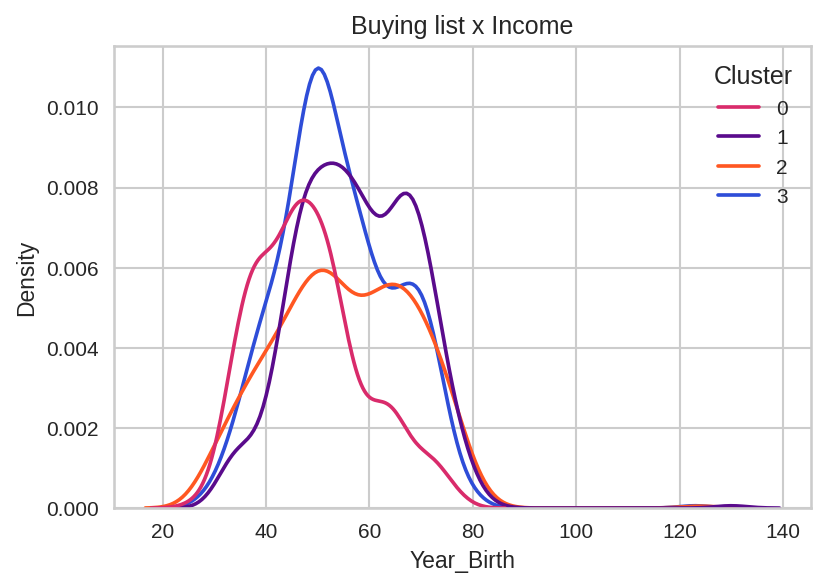

In [368]:
plt.figure(dpi=150 , figsize=(6, 4))
plt.title('Buying list x Income')
sns.kdeplot(data=df, x='Year_Birth', hue='Cluster', palette=palette)
plt.show()

We dont see regularity age with cluters.
But next move I decided to make categories with thinking about know better to bonds clusters with age.

In [369]:
df['Year_Birth'].describe()

count    2208.000000
mean       54.192935
std        11.991913
min        27.000000
25%        46.000000
50%        53.000000
75%        64.000000
max       130.000000
Name: Year_Birth, dtype: float64

In [370]:
def year_group(arg):
    if 46>arg>=27:
      return 'Group 27-45'
    elif 53>arg>=46:
      return 'Group 46-52'
    elif 64>arg>=53:
      return  'Group 53-63'
    elif arg>= 64:
      return 'Group more than 64'

In [371]:
df['Age_Group'] = df['Year_Birth'].apply(year_group)

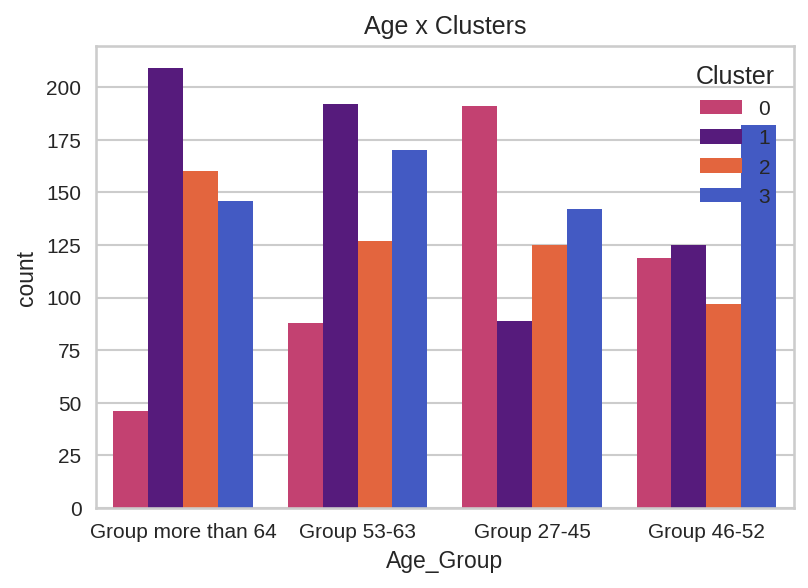

In [372]:
plt.figure(dpi=150 , figsize=(6, 4))
plt.title('Age x Clusters')
sns.countplot(data=df, x='Age_Group', hue='Cluster', palette=palette)
plt.show()

We see better graph which explain some things:
* Cluster 0 hightly in more 64 but maybe another group
* Cluster 1 hightly in 46-52 and 53-63
* Cluster 2 hightly in 27-45
* Cluster 3 hightly in more 64 and 53-64

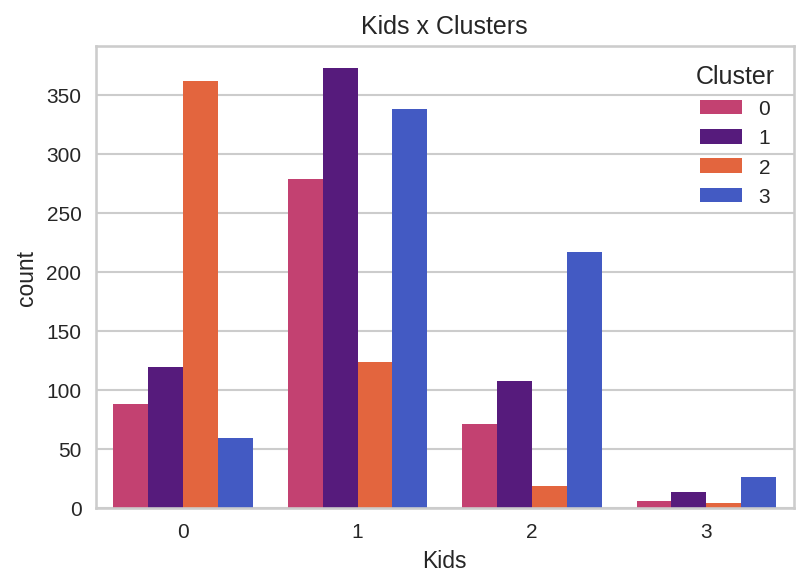

In [384]:
plt.figure(dpi=150, figsize=(6, 4))
plt.title('Kids x Clusters')
sns.countplot(data=df, x='Kids', hue='Cluster', palette=palette)
plt.show()

Cluster 0: 0 or 1 kid

Cluster 1: 1 maybe 2 kids

Cluster 2: 1 kid

Cluster 3: 1 kid

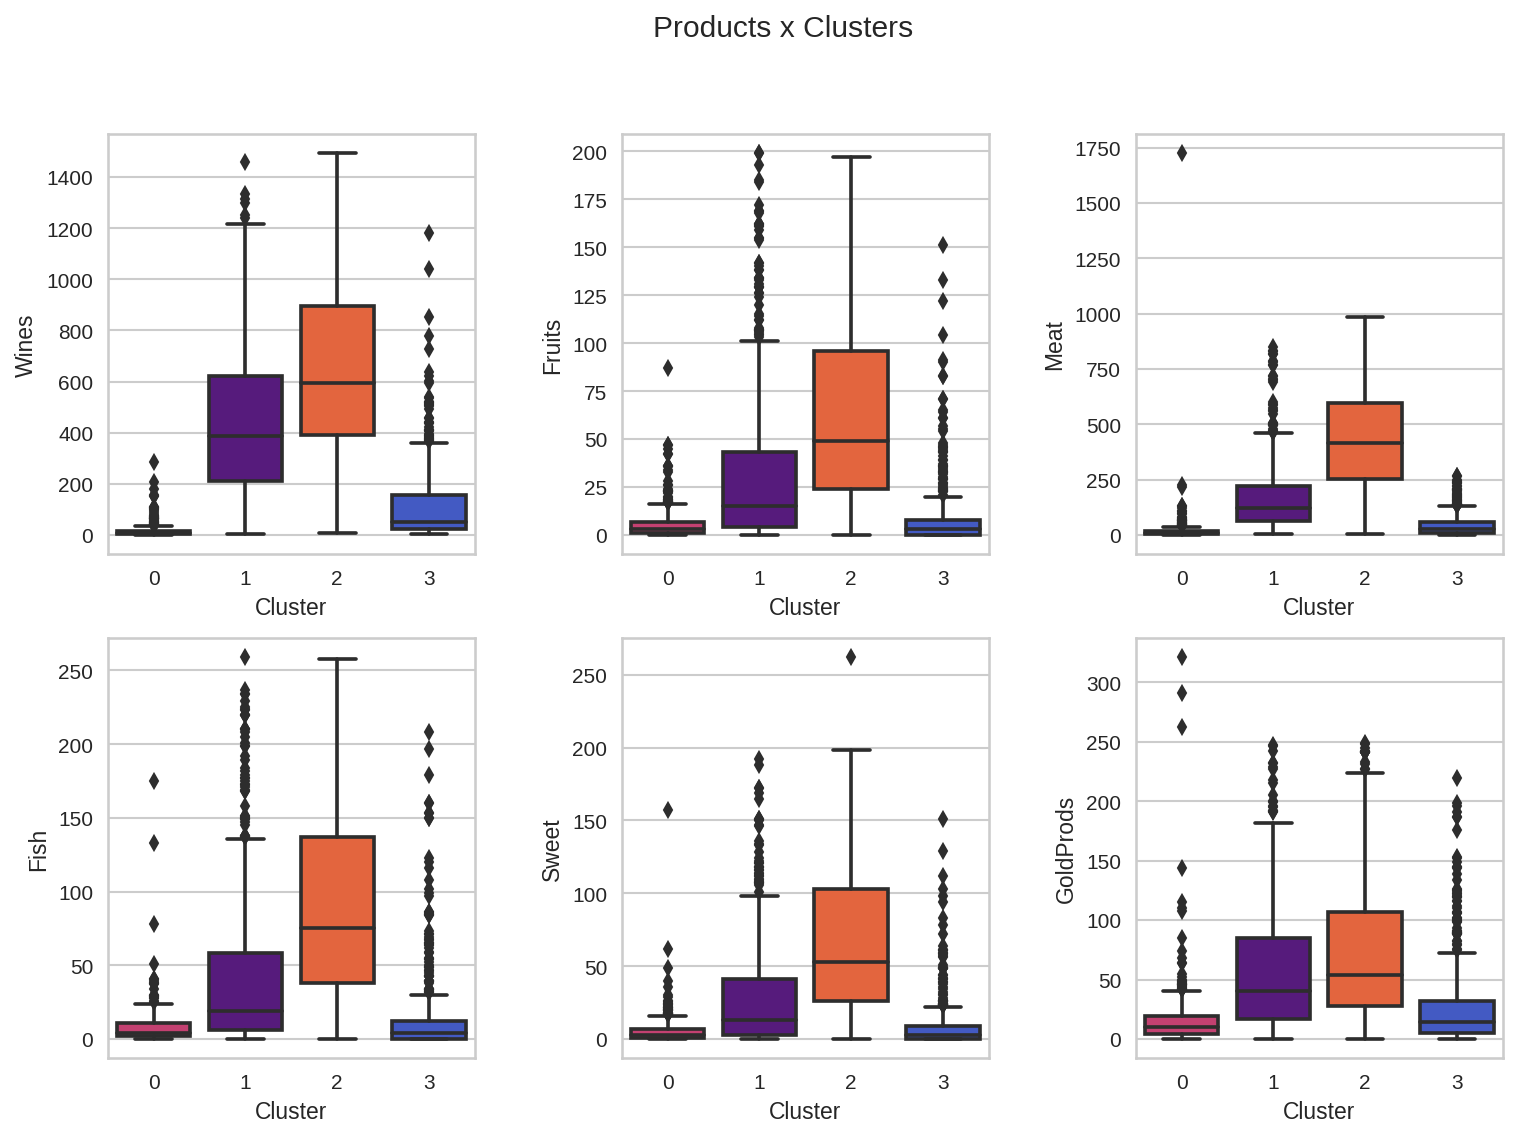

In [374]:
fig, axes = plt.subplots(2, 3, dpi=150 , figsize=(12, 8))
fig.suptitle("Products x Clusters")

l = ['Wines', 'Fruits', 'Meat', 'Fish', 'Sweet', 'GoldProds']
ax1 = axes[0][0]
ax2 = axes[0][1]
ax3 = axes[0][2]
ax4 = axes[1][0]
ax5 = axes[1][1]
ax6 = axes[1][2]
sns.boxplot(data=df, y='Wines', x='Cluster', palette=palette, ax=ax1)
sns.boxplot(data=df, y='Fruits', x='Cluster', palette=palette, ax=ax2)
sns.boxplot(data=df, y='Meat', x='Cluster', palette=palette, ax=ax3)
sns.boxplot(data=df, y='Fish', x='Cluster', palette=palette, ax=ax4)
sns.boxplot(data=df, y='Sweet', x='Cluster', palette=palette, ax=ax5)
sns.boxplot(data=df, y='GoldProds', x='Cluster', palette=palette, ax=ax6)

fig.subplots_adjust(left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=0.4,
    hspace=0.2,)

Cluster 0:
Spend a lot of all cluster and spend normal in all category.
* Likes fish, wines, fruits.

Cluster 1:
Spend low but have outliers.
* Most in wines and gold products but we also see outliers.

Cluser 2:
They spend lowest we can recomend them discount.
* Discount in Fruits, Fish, Golds

Cluster 3: Spend medium in all categories.
* But they most likely wines and Gold Products.

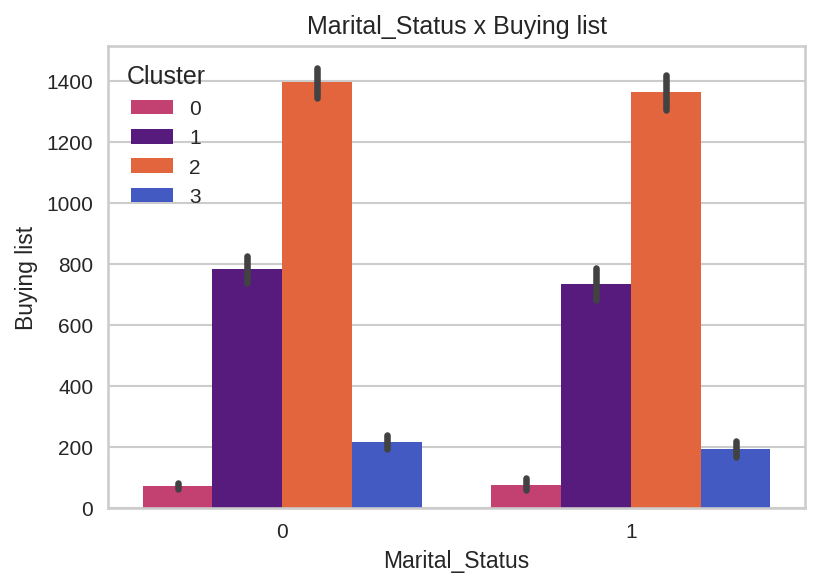

In [385]:
plt.figure(dpi=150 , figsize=(6, 4))
plt.title('Marital_Status x Buying list')
sns.barplot(data=df, x='Marital_Status', y='Buying list', hue='Cluster', palette=palette)
plt.show()

We dont see here nothing interesting

### Results of research

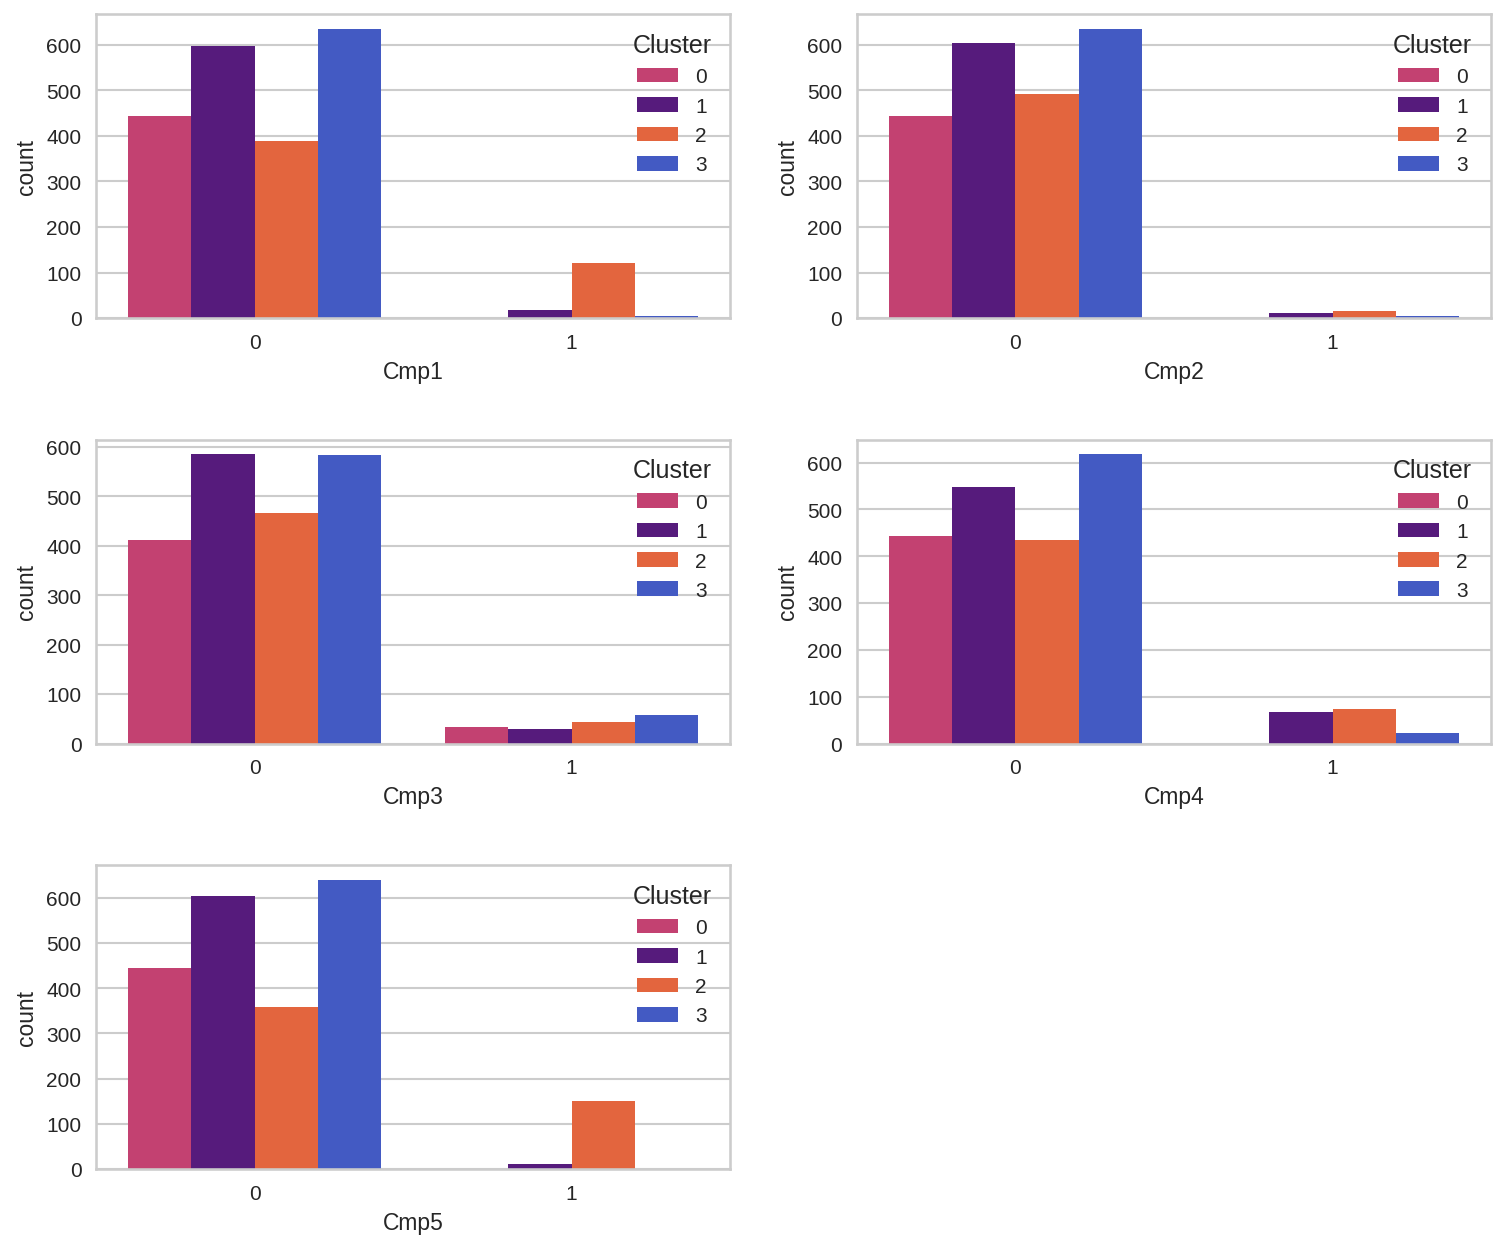

In [376]:
fig, axes = plt.subplots(3, 2, dpi=150 , figsize=(12, 10))


l = ['Cmp1', 'Cmp2', 'Cmp3', 'Cmp4', 'Cmp5']

d = {1: axes[0][0],
2: axes[0][1],
3: axes[1][0],
4: axes[1][1],
5: axes[2][0]}

for key, feature in enumerate(l, 1):

    ax = d[key]
    sns.countplot(data=df, x=feature, hue='Cluster', palette=palette, ax=ax)
    plt.xlabel(feature)

fig.delaxes(axes[2][1])

fig.subplots_adjust(left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=0.2,
    hspace=0.4,)

plt.show()

Marketing company is bad. We see that only 0 cluster accepted promotion.

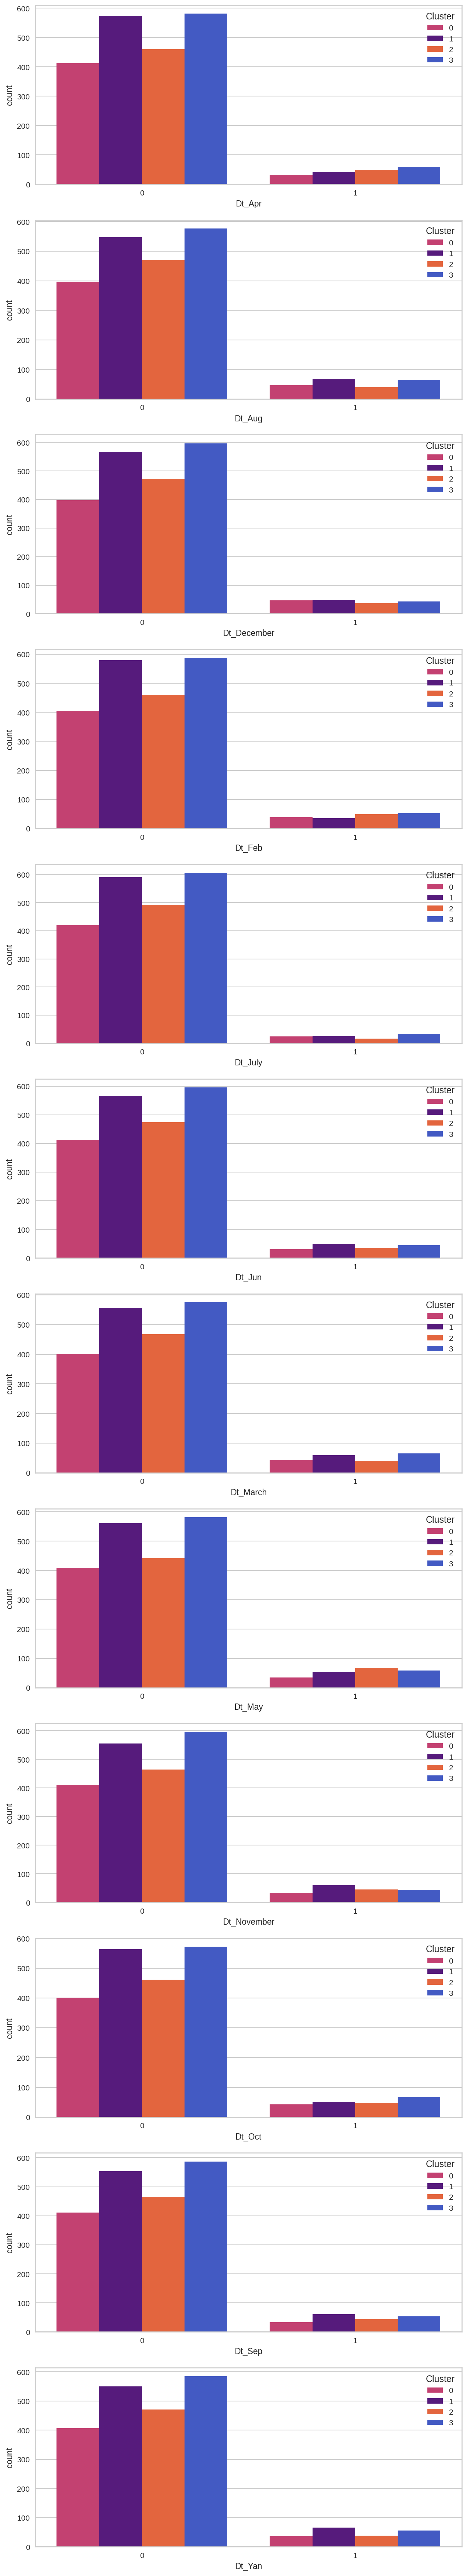

In [377]:
l = ['Dt_Apr',
       'Dt_Aug', 'Dt_December', 'Dt_Feb',
       'Dt_July', 'Dt_Jun', 'Dt_March',
       'Dt_May', 'Dt_November', 'Dt_Oct',
       'Dt_Sep', 'Dt_Yan']

fig, axes = plt.subplots(len(l), 1, dpi=150 , figsize=(10, len(l)*5))

for idx, feature in enumerate(l):
    ax = axes[idx]
    sns.countplot(data=df, x=feature, hue='Cluster', palette=palette, ax=ax)

plt.show()

Cluster 0 - Best Dt in May, worst in July

Cluster 1 - Best Dt in Oct, worst in July

Cluster 2 - Best Dt in Aug, worst in July

Cluster 3 - Best Dt in Aug, worst in July

It means that May, Oct, Aug is best time to start working with a client.

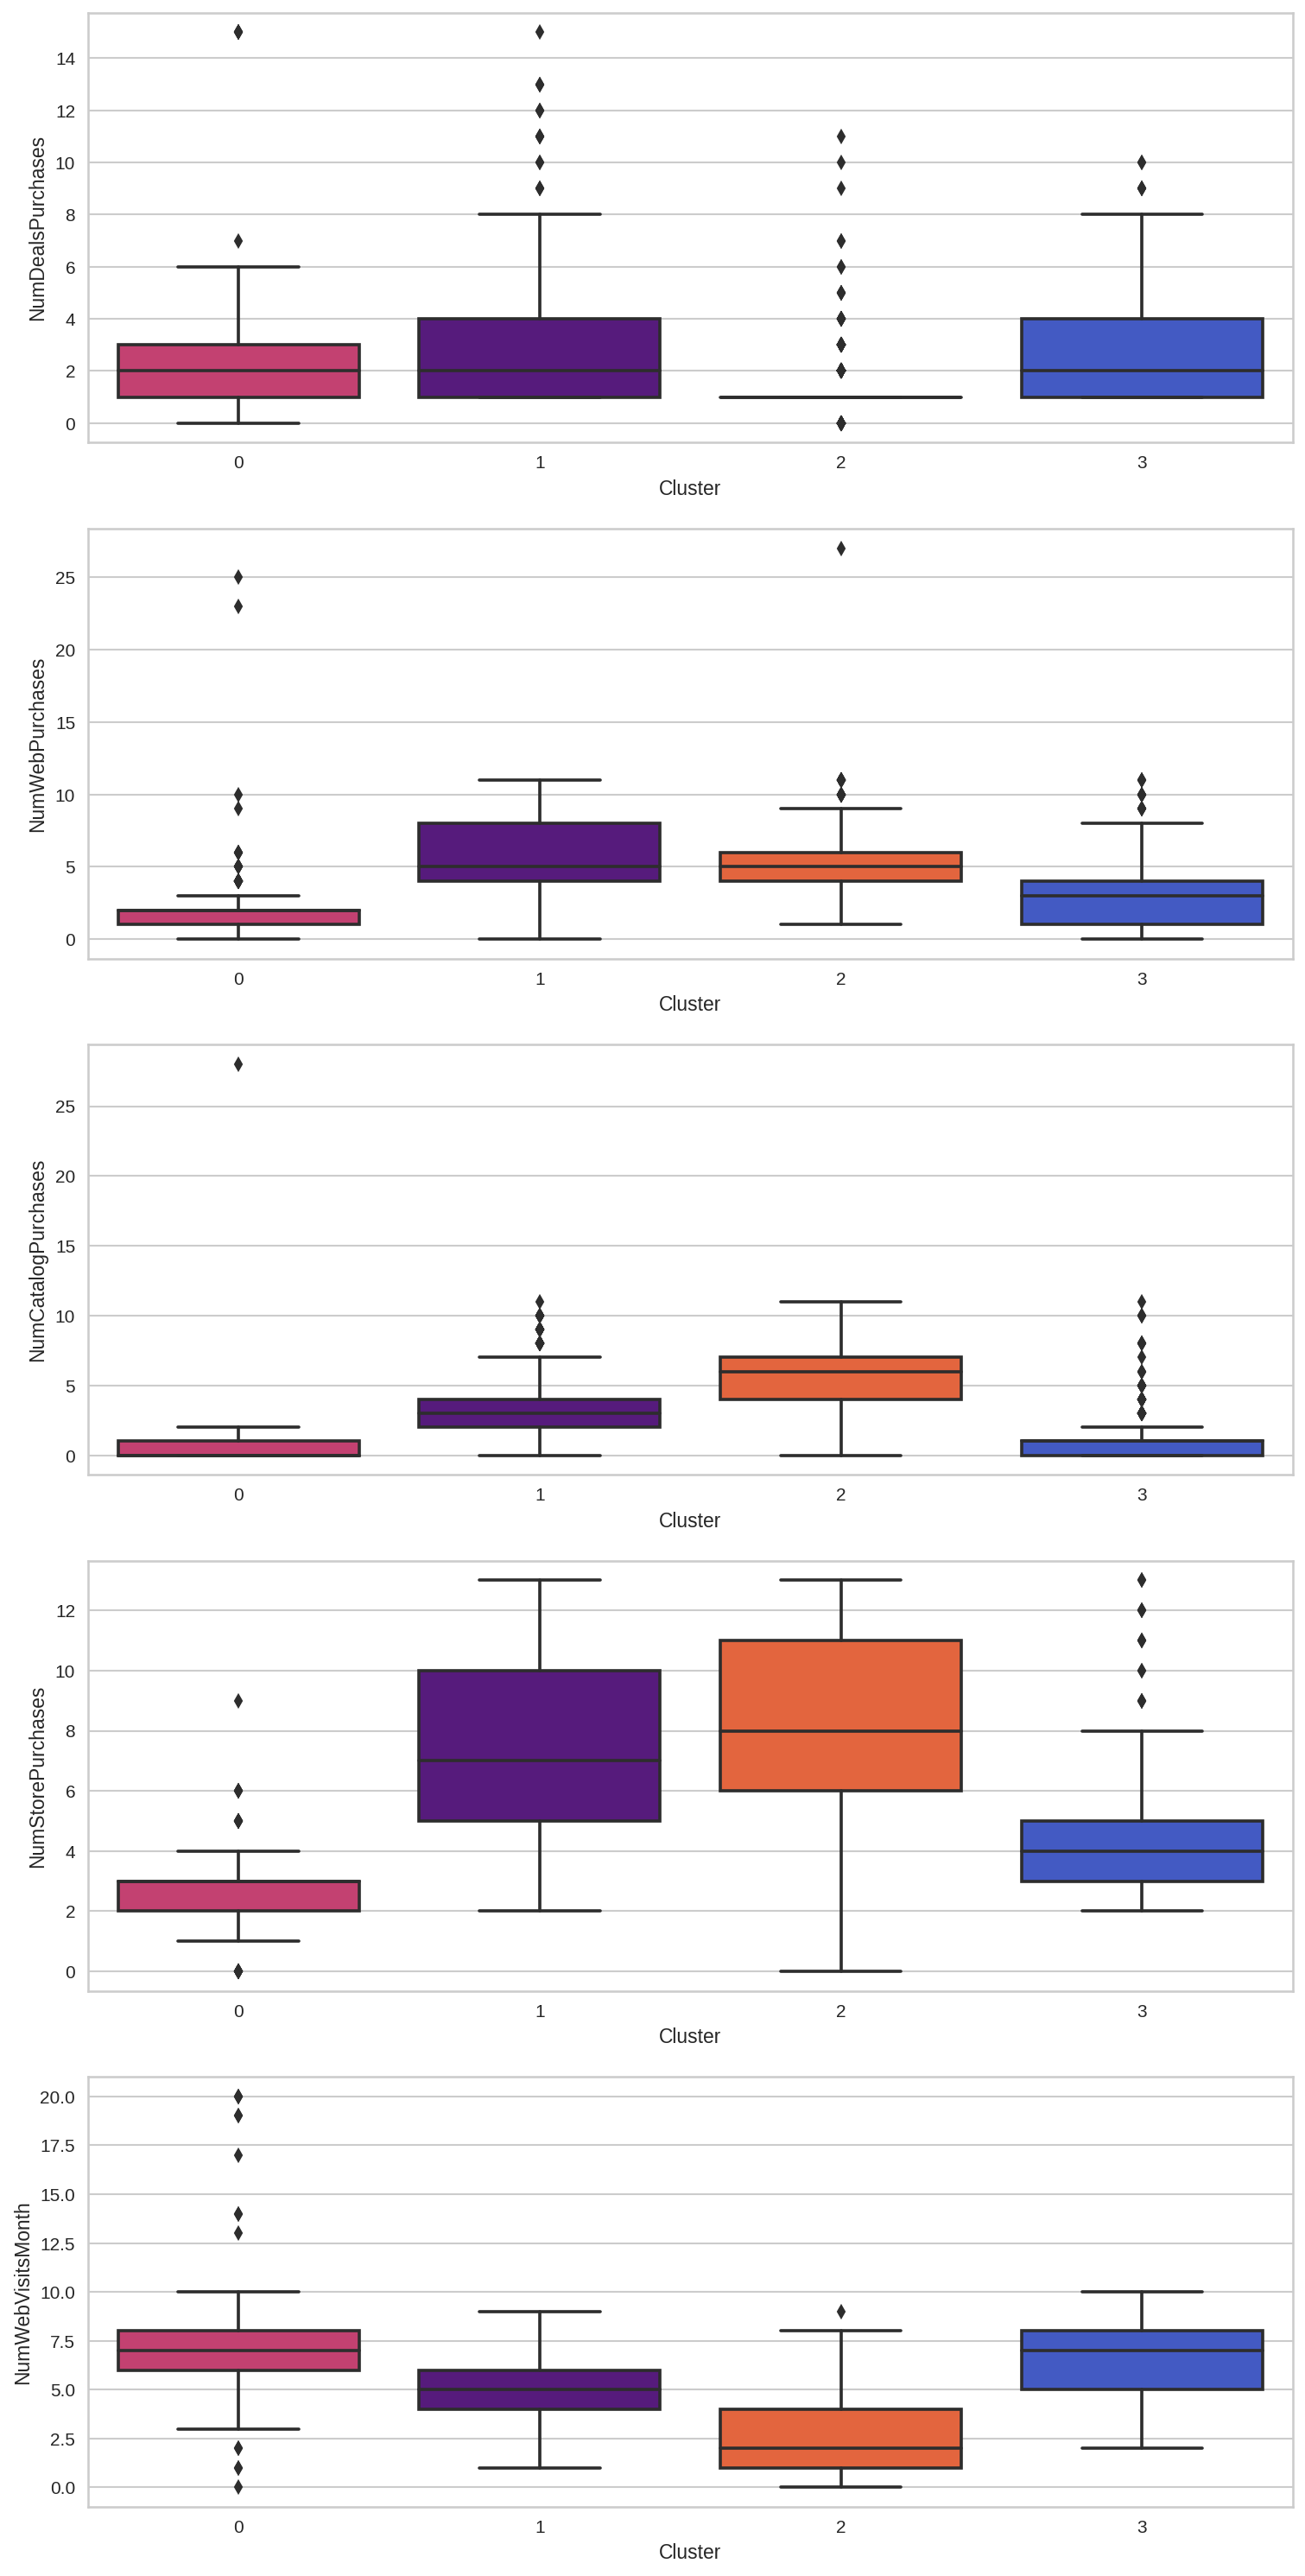

In [378]:
l = ['NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']

fig, axes = plt.subplots(len(l), 1, dpi=150 , figsize=(12, len(l)*5))

for idx, feature in enumerate(l):
    ax = axes[idx]
    sns.boxplot(data=df, y=feature, x='Cluster', palette=palette, ax=ax)

plt.show()

We see that cluster 0 is too rich to deals purchases.

Also we see that cluster 0 and cluster 2 prefer buy in Store.

Cluster 3 more than other visit website.

Cluser 1 dont buy in catalog.

Cluster 4 have medium statistic.

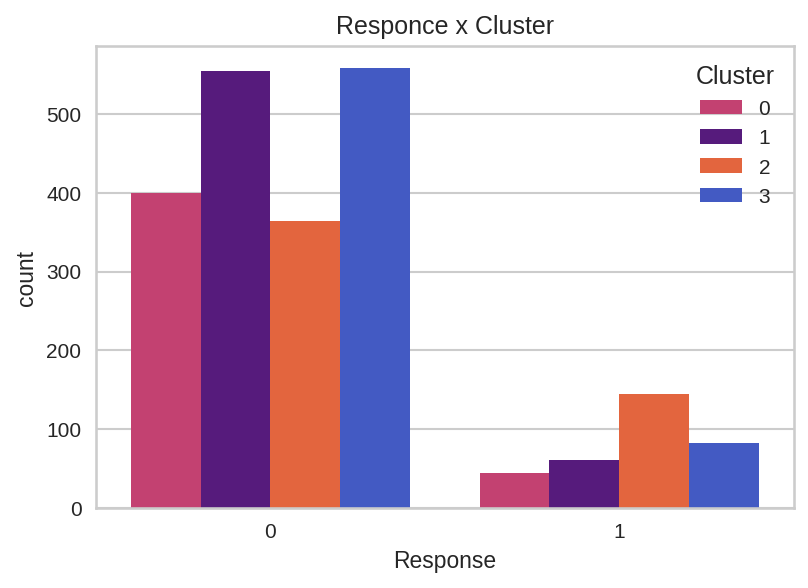

In [387]:
plt.figure(dpi=150 , figsize=(6, 4))
plt.title('Responce x Cluster')
sns.countplot(data=df, x='Response', hue='Cluster', palette=palette)
plt.show()

In [380]:
data = df.groupby('Response')['Cluster'].count().sort_values()
data

Response
1     333
0    1875
Name: Cluster, dtype: int64

In [381]:
print(f'Persentage accepted last promotion {round(333*100/len(df), 3)}%')

Persentage accepted last promotion 15.082%


Last campaign was better because it have 15% acception, it's nice result using information that last promotions acception in averege 7%
Cluster 0 is best in this Promo!!!

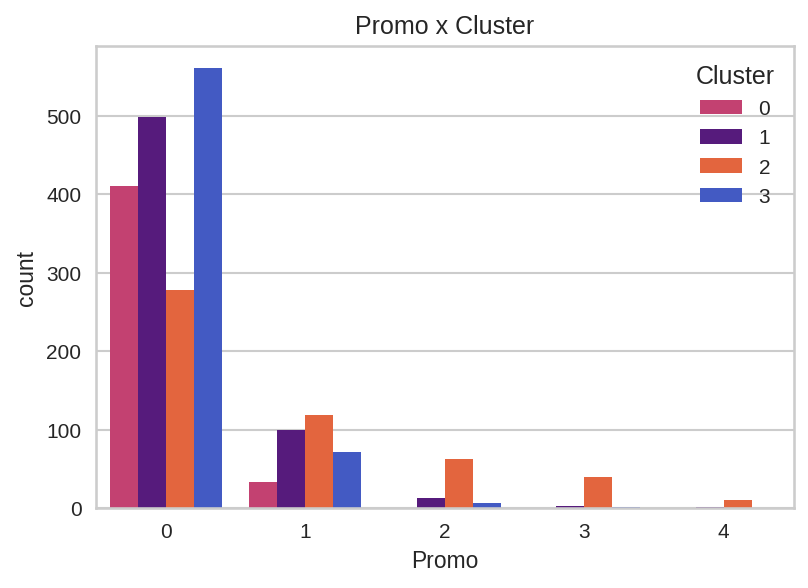

In [388]:
plt.figure(dpi=150 , figsize=(6, 4))
plt.title('Promo x Cluster')
sns.countplot(data=df, x='Promo', hue='Cluster', palette=palette)
plt.show()

Cluster 0 is better to acception promotion

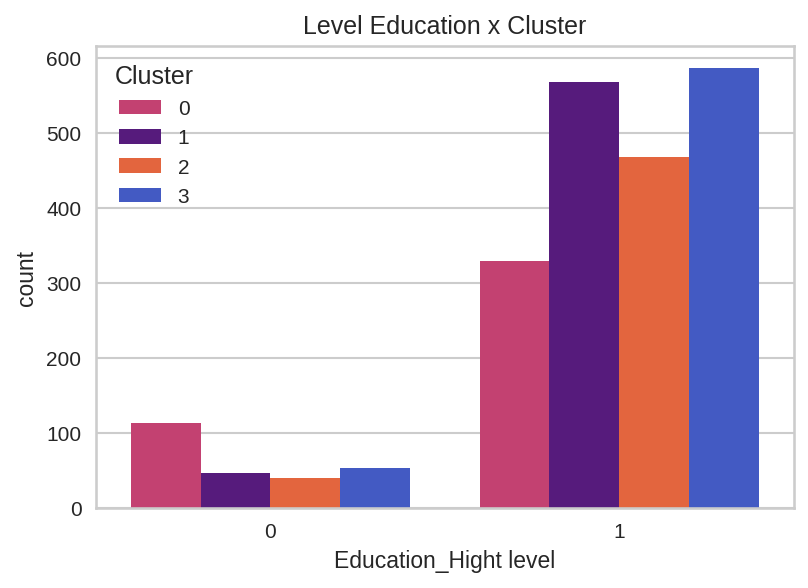

In [389]:
plt.figure(dpi=150 , figsize=(6, 4))
plt.title('Level Education x Cluster')
sns.countplot(data=df, x='Education_Hight level', hue='Cluster', palette=palette)
plt.show()

We see that cluster 1 and 3 have hight level of education.

## Results


### In this part we have results of all work and recomendations to cooperate with them.
****


**Cluster 0** (People without children, potential clients)
****
Income: Hight

Buying: Hight

Age: ofter more 64 y.o but can be and lower 

Kids: likely to 0 or sometimes 1

Likes: fish, wines, fruits

Acception Promo: Good to promotion

Time to deal with: May

Where often buy: Store (Dont want a discount)

Education: Hight and low

Last Promotion: have best results
****
**Cluster 1** (Parents, people middle age)
****
Income: Medium

Buying: Low

Age: ofter 46-63 

Kids: 1-2 children

Likes: wines, gold

Acception Promo: 3 promo or last promo better to use

Time to deal with: Oct

Where often buy: Discount, Web (No catalog)

Education: Seems to hight

Last Promotion: Results under 100. Good in general but bad like promo
****
**Cluster 2** (Poor people middle age, students)
****
Income: Low

Buying: Low

Age: ofter 27-45 

Kids: 1 child

Likes: Fruits, Fish, Golds but need to discount!

Acception Promo: 3 promo or last promo better to use

Time to deal with: Aug

Where often buy: Discount, Store (often visit website)

Education: hight and sometimes medium

Last Promotion: Results under 100. Good in general but bad like promo
****
**Cluster 3** (potential clients, rich old people)
****
Income: Hight

Buying: Medium

Age: often 53 or more 

Kids: 1 child

Likes: Vines, Gold

Acception Promo: 4 promo or last promo better to use

Time to deal with: Aug

Where often buy: Discount, Store

Education: often hight

Last Promotion: Results like 4 promotion


### Recomendations
* Promotion department need to revise attention to 3 Campaign.
* Most people spend their money if they deal with company in Aug, Sep, Nov.
* Marital status make low infuence but single people spend a little bit more.
* People without kids or 1 kid spend a lot.
* Hightly educated people often spend more.
* Store purchases and Web views have results better than other but web have low purchases, Catalog have worst statistic but it's catalog, maybe in company this results are normal.
* Second marketing campaign failed. Average persent of involiving 5.94%, best marketing was at 4 Cmp.
* Show this clusters to marketing department to see their opinion.